# Finding nearest neighbours using min-hashing

In this notebook, I apply min-hashing to solve the nearest neighbours' problem on Amazon reviews. 


## Dataset(s)
The data is a ```.json``` file. Each line describes a review and has the following format:

```
{"reviewerID": "A14CK12J7C7JRK", "asin": "1223000893", "reviewerName": "Consumer in NorCal", "helpful": [0, 0], "reviewText": "I purchased the Trilogy with hoping my two cats, age 3 and 5 would be interested.  The 3 yr old cat was fascinated for about 15 minutes but when the same pictures came on, she got bored.  The 5 year old watched for about a few minutes but then walked away. It is possible that because we have a wonderful courtyard full of greenery and trees and one of my neighbors has a bird feeder, that there is enough going on outside that they prefer real life versus a taped version.  I will more than likely pass this on to a friend who has cats that don't have as much wildlife to watch as mine do.", "overall": 3.0, "summary": "Nice Distraction for my cats for about 15 minutes", "unixReviewTime": 1294790400, "reviewTime": "01 12, 2011"}
```
## Analysis goal
To the purpose of this analysis, we view each user as the set of items s/he reviewed. Given a user u, we are interested in all users, whose baskets (i.e., the sets of items they purchased) have Jaccard similarities with u's that exceed a given threshold $\theta$. The right value for $\theta$ is something that is normally the result of a separate analysis.

## First experiment
The first experiment concerns the accuracy and efficiency of min-hashing to the purpose of achieving the goal above. To this purpose, we first divide our dataset into a training and a test set. To begin with, we use the following simple criterion. Given the source ```.json``` file, we produce two files ```train.json``` and ```test.json``` as follows: we remove all reviews of the first ```n_test``` users and store them to ```test.json```. The remaining reviews (possibly the vast majority) are stored to ```train.json```. In this example we chose ```n_test = 100```.

We then build an LSH table associated to all users in the training set following the standard approach, as is implemented in the ```datasketch``` package, in particular by the ```MinHash``` and ```MinHashLSH``` classes.

Next, for each user in the test, we identify all users whose true (using exhaustive search) or estimated (using min-hashing) Jaccard similarity is above the desired threshold $\theta$. For each user, we keep track of i) times to compute neighbourhood for exact and approximate method, ii) precision, iii) recall.

Finally, we compute average speed-up, precision and recall over the ```n_test``` users considered.

We first import the necessary libraries and define a function for exact Jaccard similarity computation. We also define the value of $\theta$ here.

In [7]:
# Imports: needed only once
import json
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve
from datasketch import MinHash, MinHashLSH
from nltk.metrics.scores import (precision, recall)

## a and b are sets
def jaccard(a, b):
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

The following block creates 5 different couples of the kind *(train_set, test_set)* that will be used for a 5-fold validation.

In [8]:

data = "./data/data.json"
train = "./data/train"
test = "./data/test"
n_test = 100


for i in range(5):
    f_in = open(data, "r") ## Original data file
    f_train = open(train+str(i)+".json", "w") ## Training set
    f_test = open(test+str(i)+".json", "w") ## Test set

    ## We collect first 100 Reviewers and store their ids
    test_list = [] ## This contains first n_test reviewers' ids

    # CHANGE: randomly choose 100 entries between the lines of f_in (5 times)
    lines = f_in.readlines()

    while(len(test_list) < n_test):
        t_line = random.choice(lines)
        jrecord = json.loads(t_line)
        if jrecord["reviewerID"] not in test_list:
            test_list.append(jrecord["reviewerID"])


    ## We next scan the whole data file and produce the training and test files
    ## We remove all reviews for test users from original dataset
    f_in.seek(0)
    for line in f_in:
        jrecord = json.loads(line)
        if jrecord["reviewerID"] in test_list:
            f_test.write(line)
        else:
            f_train.write(line)

f_in.close()
f_train.close()
f_test.close()

We build a list of dictionaries where the entry *i* is a dictionary of users in the *i-th* training set. Each user is the set of product ids s/he reviewed

In [ ]:
train_dictionaries = []

for i in range (5):
    f_train = open("./data/train" + str(i) + ".json")
    train_dict = {}
    for line in f_train:
        jrecord = json.loads(line)
        uid = jrecord["reviewerID"]
        if uid in train_dict:
            train_dict[uid].add(jrecord["asin"])
        else:
            train_dict[uid] = {jrecord["asin"]}
    train_dictionaries.append(train_dict)
    
f_train.close()

#the list train_dictionaries contains 5 different dictionaries; one for every train_set

We do the same for a list of the dictionaries for the test sets.

In [ ]:
test_dictionaries = []

for i in range(5):
    f_test = open("./data/test" + str(i) + ".json")
    test_dict = {}
    for line in f_test:
        jrecord = json.loads(line)
        uid = jrecord["reviewerID"]
        if uid in train_dictionaries[i]:
            test_dict[uid].add(jrecord["asin"])
        else:
            test_dict[uid] = {jrecord["asin"]}
    test_dictionaries.append(test_dict)

f_test.close()

#the list test_dictionaries contains 5 different dictionaries; one for every test_set

In [44]:
theta = pl.frange(0.05,0.15,0.01)

#tot_prec and tot_rec will contain all the 16 precision and recall values computed for every theta
#as the average of a 5-fold validation

tot_prec = []
tot_rec = []
prec_list = []
rec_list = []

#iterator over all the values of theta
for i in tqdm(theta):
        
    tot_prec.append(0)
    tot_rec.append(0)
      
    #iterator for the 5-fold validation
    for k in range(5):
           
        #lsh: data structure which supports the query for a given minhash
        lsh = MinHashLSH(threshold=i, num_perm=128)
        
        for uid in train_dictionaries[k]:
            m = MinHash(num_perm=128)
            for pid in train_dictionaries[k][uid]:
                m.update(pid.encode('utf8'))
            lsh.insert(uid, m)
                
        #lsh is the LSH data structure for the k-th training set
        
                      
        apx_neighbors = {}
        exact_neighbors = {}
        
        for uid in test_dictionaries[k]:
            m = MinHash(num_perm=128)
            for pid in test_dictionaries[k][uid]:
                m.update(pid.encode('utf8'))
            #for the user uid compute all the users of the training set whose signature has
            #a similarity >theta (approximated neighbors)
            apx_neighbors[uid] = lsh.query(m)
            exact_neighbors[uid] = []
            for other in train_dictionaries[k]:
                if jaccard(test_dictionaries[k][uid], train_dictionaries[k][other]) > i:
                    #add all the true neighbors according to the theta threshold value
                    exact_neighbors[uid].append(other)
                    
                    
        prec_list.append(0)
        cp = 0
        rec_list.append(0)
        cr = 0

        for uid in test_dictionaries[k]:
            p = precision(set(exact_neighbors[uid]), set(apx_neighbors[uid]))
            if p != None:
                cp += 1
                prec_list[-1] += p
            r = recall(set(exact_neighbors[uid]), set(apx_neighbors[uid]))
            if r != None:
                cr += 1
                rec_list[-1] += r
        
        #the following lists contain prec and rec average value for each of the 5 test/train set
        prec_list[-1] = prec_list[-1]/cp
        rec_list[-1] = rec_list[-1]/cr
      
    #tot_prec and tot_rec contain the 16 average values obtained by the 5-fold validation
    tot_prec[-1] = np.mean(prec_list)
    tot_rec[-1] = np.mean(rec_list)
    prec_list = []
    rec_list = []
    

# here we should have the three lists prec, rec and theta
print("Precision list: ", tot_prec)
print("Recall list: ", tot_rec)
print("Theta list: ", theta)


100%|██████████| 11/11 [19:51<00:00, 108.36s/it]

Precision list:  [0.8655891835526256, 0.8928966403228312, 0.868334342418086, 0.8334260490528644, 0.9044546450139169, 0.8348489725015508, 0.8348489725015508, 0.7719212889393201, 0.6804671098587072, 0.6880831555715045, 0.5683502855790241]
Recall list:  [0.8826124352381253, 0.9543664647762921, 0.94187208954906, 0.9355171459463938, 0.7474498542856665, 0.7979685586199194, 0.7979685586199194, 0.8237131282332101, 0.8497840817146327, 0.8235646586803499, 0.8229425847457617]
Theta list:  [0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15]


We finally plot the curves for precision and recall.

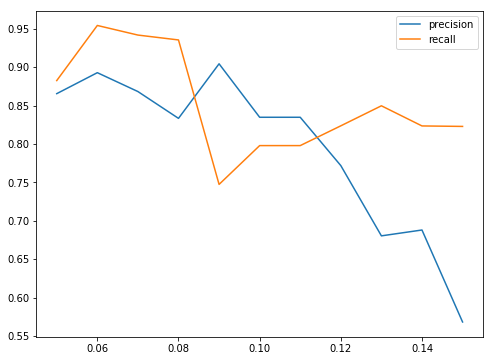

In [45]:
plt.figure(figsize=(8,6))
plt.plot(theta,tot_prec, label="precision")
plt.plot(theta,tot_rec, label="recall")
leg = plt.legend()


plt.show()